## Merges heterogenous data sets by their business name and address. 

Data used:

- ACHD_restaurant_inspection.csv: Food facility/restaurant inspection data conducted by ACHD (Allegheny County Health Department) from 2012 to mid of 2016. https://data.wprdc.org/dataset/allegheny-county-restaurant-food-facility-inspection-violations

- Yelp API: Yelp API has been used to find the most closest matched data from the existing Yelp data file (processed in the previous file).

In [1]:
# Load packages
import json
import csv
import pandas as pd
import numpy as np
import difflib
import json
import requests
from urllib.parse import urlencode
import time
import ast

# 1.1. ACHD Food Facility Inspection Data

In [2]:
# Load the original ACHD food facility inspection data
insp = pd.read_csv('../dataset/ACHD_restaurant_inspection.csv', dtype={'ZIP': np.int32, 'ID': np.int64}, encoding='latin-1')

In [3]:
print("The inspection dataset has {} inspection records for the {} food facilities in Allegheny County".format(len(insp['Encounter'].unique()), len(insp['ID'].unique())))

The inspection dataset has 40736 inspection records for the 10097 food facilities in Allegheny County


In [4]:
col_names = list(np.delete(insp.columns.values, [0, 1, 3, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]))

In [5]:
col_names

['ID',
 'Facility Name',
 'Bus St Date',
 'Description',
 'NUM',
 'Street',
 'City',
 'State',
 'ZIP']

In [6]:
insp_df = insp.groupby(col_names, as_index=False)['Low', 'Medium', 'High'].sum()

In [38]:
insp_df.to_csv('../dataset/insp_df_all.csv')

# 1.2. Call Yelp API to have 'yelp_id', 'yelp_name', 'yelp_address', and 'yelp_zip' in the dataframe, insp_df

Calling Yelp API will take hours to complete.

Skip this if you have done this.

In [6]:
# Load API Keys
keys = json.load(open('../api_key.json'))
CLIENT_ID = keys['CLIENT_ID']
CLIENT_SECRET = keys['CLIENT_SECRET']

In [7]:
# API constants
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/' 
TOKEN_PATH = '/oauth2/token'
GRANT_TYPE = 'client_credentials'

In [8]:
# Get access_token
data = urlencode({
        'client_id': CLIENT_ID,
        'client_secret': CLIENT_SECRET,
        'grant_type': GRANT_TYPE,
    })
r = requests.request('POST', "https://api.yelp.com/oauth2/token", data=data)
access_token = r.json()['access_token']
headers = {
        'content-type': 'application/x-www-form-urlencoded',
        'Authorization': 'Bearer %s' % access_token,
    }

In [35]:
SEARCH_LIMIT = 2
for i in insp_df.index:
    # Parameters for query
    if (i+1) % 2000 == 0: # time sleep for every 2000 query
        print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
        time.sleep(900) # rest 15 mins
        
    name = insp_df.iloc[i]['Facility Name']
    address = '{0} {1}, {2}, PA'.format(insp_df.iloc[i]['NUM'], 
                                 insp_df.iloc[i]['Street'], 
                                 insp_df.iloc[i]['City'])
    url_params = {
        'term': name.replace(' ', '+'),
        'location': address.replace(' ', '+'),
        'limit': SEARCH_LIMIT
    }
    
    # Execute the query
    try:
        r = requests.get(API_HOST+SEARCH_PATH, data = data, headers=headers, params=url_params) # radius
    except requests.exceptions.ConnectionError:
        r.status_code = "Connection refused"
        print(r.status_code)
        
    # Fills 'yelp_id', 'yelp_name', 'yelp_address', and 'yelp_zip' with the results of the query
    try:
        data = r.json()
        if data['total'] > 0: # Run if there are results returned
            insp_df.loc[i, 'yelp_id'] = data['businesses'][0]['id']
            insp_df.loc[i, 'yelp_name'] = data['businesses'][0]['name']
            insp_df.loc[i, 'yelp_address'] = data['businesses'][0]['location']['address1']
            insp_df.loc[i, 'yelp_zip'] = data['businesses'][0]['location']['zip_code']
    except:
        print("=======================")
        print(i, name, address)
        print(r.text)

2017-12-01 06:16:26


In [54]:
# Remove food facility records with no correspondant 'yelp_id'
iy_match = insp_df.loc[pd.isnull(insp_df['yelp_id'])!=True]
iy_match

,ID,Facility Name,Bus St Date,Description,NUM,Street,City,State,ZIP,Low,Medium,High,yelp_id,yelp_name,yelp_address,yelp_zip
1,17,Bell's Market,1984-06-17,Retail/Convenience Store,603,Braddock Avenue,Braddock,PA,15104,84,24,16,belle-river-artisan-market-pittsburgh,Belle River Artisan Market,20TH Street And Penn Ave,15222
2,59,Shadyside Market,1984-06-17,Retail/Convenience Store,5414,Walnut St,Pittsburgh,PA,15232,11,2,5,shadyside-market-and-deli-pittsburgh,Shadyside Market & Deli,5414 Walnut St,15232
3,110,Hamms Market,1984-06-17,Packaged Food Only,1239,Itin St,Pittsburgh,PA,15212,False,False,False,n-stuff-music-pittsburgh,N Stuff Music,468 Freeport Rd,15238
4,118,Tom Friday's Market,1984-06-17,Retail/Convenience Store,3639,California Ave,Pittsburgh,PA,15212,43,13,8,tom-fridays-market-pittsburgh,Tom Fridays Market,3639 California Ave,15212
6,213,The Strip District Meats,1970-01-01,Retail/Convenience Store,2123,Penn Avenue,Pittsburgh,PA,15222,20,1,2,strip-district-meats-pittsburgh,Strip District Meats,2123 Penn Ave,15222
7,237,Bakers Dairy,1980-01-01,Retail/Convenience Store,7300,Hamilton Ave,Pittsburgh,PA,15208,11,8,1,gluuteny-bakery-pittsburgh-2,Gluuteny Bakery,1923 Murray Ave,15217
8,253,Leonard Labriola Foods,1969-04-01,Chain Supermarket,121,Hulton Road,Verona,PA,15147,15,3,3,leonard-labriolas-foods-pittsburgh,Leonard Labriola's Foods,121 Hulton Rd,15235
9,259,Merante Bros,1984-06-17,Retail/Convenience Store,6,Marion St,Pittsburgh,PA,15219,True,NaN,NaN,merante-brothers-italian-american-market-pitts...,Merante Brothers Italian American Market,6 Marion St,15219
10,262,Community Super Market,1970-01-01,Supermarket,1117,Milltown Rd,Verona,PA,15147,37,16,12,community-supermarket-verona,Community Supermarket,1117 Milltown Rd,15147
11,294,Podmilsak's Market,1950-01-01,Retail/Convenience Store,200,Herron Avenue,Cheswick,PA,15024,33,13,13,podmilsaks-market-cheswick,Podmilsak's Market,200 Herron Ave,15024


# 1.3. Merge Yelp ID to Yelp dataset by name and address

In [56]:
# Load the Yelp dataset
# This will be merged to the existing dataset, 'iy_match', which includes ACHD inspection data with 'yelp_id'
# 'yelp_id' is the unique key to merge the two datasets
yelp = pd.read_csv('../dataset/ac_all_business.csv')
yelp = yelp.drop(['Unnamed: 0', 'is_open', 'hours', 'latitude', 'longitude'], axis=1)

In [59]:
# Merge the inspection data and Yelp main data based on yelp name and address
iy_merged = iy_match.merge(yelp, left_on=['yelp_name', 'yelp_address'], right_on=['name', 'address']) # inner join

In [62]:
print(len(iy_merged.index))
print((pd.isnull(iy_merged['business_id'])).value_counts())

4047
False    4047
Name: business_id, dtype: int64


In [78]:
# Include food facilities only (not other business type)
# Category includes restaurant, bar, bakery, caterer, cafe, grocery, food, and nightlife
iy_food = iy_merged.loc[(iy_merged['categories'].str.contains('Restaurant') | iy_merged['categories'].str.contains('Bar')| iy_merged['categories'].str.contains('Bakery')| iy_merged['categories'].str.contains('Caterer')| iy_merged['categories'].str.contains('Cafe')| iy_merged['categories'].str.contains('Grocery')| iy_merged['categories'].str.contains('Food') | iy_merged['categories'].str.contains('NightLife'))]

In [79]:
iy_food.shape

(3498, 27)

In [80]:
iy_food.columns

Index(['ID', 'Facility Name', 'Bus St Date', 'Description', 'NUM', 'Street',
       'City', 'State', 'ZIP', 'Low', 'Medium', 'High', 'yelp_id', 'yelp_name',
       'yelp_address', 'yelp_zip', 'address', 'attributes', 'business_id',
       'categories', 'city', 'name', 'neighborhood', 'postal_code',
       'review_count', 'stars', 'state'],
      dtype='object')

## 1.4. Remove inaccurate match using some fuzzy matching street number, street name, and restaurant name

In [83]:
# Change yelp address system to fit into the address system in the ACHD inspection data
iy_food = iy_food.reset_index(drop=True)
iy_food['num'] = iy_food['address'].str.split(' ').str[0]
iy_food['street'] = iy_food['address'].str.split(' ').str[1]
iy_food['Street0'] = iy_food['Street'].str.split(' ').str[0]
iy_food['num0'] = iy_food['num'].str.split(r'\D').str[0]
iy_food['NUM0'] = iy_food['NUM'].str.split(r'\D').str[0]

In [133]:
# Get the number of differences in words in the restaurant names

for i in iy_food.index:
    intersection = len(set(iy_food['name'][i].split()).intersection(set(iy_food['Facility Name'][i].split())))
    iy_food.loc[i, 'diff_name'] = intersection

In [146]:
# Get the number of differences in street numbers

iy_food['num0'] = pd.to_numeric(iy_food['num0'])
iy_food['NUM0'] = pd.to_numeric(iy_food['NUM0'])

for i in iy_food.index:
    difference = abs(iy_food.iloc[i]['NUM0'] - iy_food.iloc[i]['num0'])
    if difference>4:
        iy_food.loc[i, 'diff_num']=5
    else:
        iy_food.loc[i, 'diff_num']=difference

In [105]:
# Get street name match
for i in iy_food.index:
    if iy_food.iloc[i]['Street0'] != iy_food.iloc[i]['street']:
        iy_food.loc[i, 'diff_street']=1
    else:
        iy_food.loc[i, 'diff_street']=0       

In [155]:
iy_food = iy_food.loc[(iy_food['diff_num']<=2) & (iy_food['diff_name']>=1)]

In [156]:
iy_food = iy_food.reset_index(drop=True)

In [157]:
iy_food.to_csv('../dataset/iy_food_matching.csv')

# 2.1 Remove duplicate restaurants in the dataset

In [7]:
iy_food = pd.read_csv('../dataset/iy_food_matching.csv')

In [10]:
iy_food_id_dict = iy_food.sort_values('Low', ascending=False).loc[iy_food.sort_values('Low', ascending=False).duplicated('yelp_id', keep='first')][['ID', 'Bus St Date', 'yelp_id']]
iy_food_id_dict.to_csv('../dataset/iy_food_id_dict.csv')

In [15]:
iy_food_id_dict['ID'].shape

(144,)

In [11]:
print(iy_food_id_dict.shape)
iy_food_id_dict.head(3)

(144, 3)


,ID,Bus St Date,yelp_id
1210,200907210007,2009-07-20,rivers-casino-pittsburgh-5
1033,201401090005,2014-01-14,aspinwall-beans-n-cream-aspinwall
1017,201501140007,2015-01-05,foxs-pizza-den-west-mifflin


In [95]:
# Replace ID with cleansed ID based on 'yelp_id
for i in iy_food.iterrows():
    for j in iy_food_id_dict.iterrows():
        if i[1]['yelp_id']==j[1]['yelp_id']:
            iy_food.loc[i[0], 'ID_dict'] = j[1]['ID']
            iy_food.loc[i[0], 'bus_st_date'] = j[1]['Bus St Date']

In [96]:
iy_food.to_csv('../dataset/iy_food_matching_uniq.csv')

In [97]:
id_unify_dict = iy_food[['ID', 'ID_dict', 'bus_st_date']]
id_unify_dict = id_unify_dict[~pd.isnull(id_unify_dict['ID_dict'])]
id_unify_dict['ID_dict']=id_unify_dict['ID_dict'].astype(np.int64)

In [106]:
id_unify_dict.head(5)

,ID,ID_dict,bus_st_date
28,1851,1851,1960-01-01
29,201303220002,1851,1960-01-01
34,200212130003,200212130003,2002-11-27
35,201503090002,200212130003,2002-11-27
68,7461,7461,1970-01-10


# 2.2. Matching Data to the original inspection data

In [107]:
# Load the original ACHD food facility inspection data
insp = pd.read_csv('../dataset/ACHD_restaurant_inspection.csv', dtype={'ZIP': np.int32, 'ID': np.int64}, encoding='latin-1')

In [108]:
print("The inspection dataset has {} inspection records for the {} food facilities in Allegheny County".format(len(insp.index), len(insp['ID'].unique())))

The inspection dataset has 160817 inspection records for the 10097 food facilities in Allegheny County


In [109]:
# Remove unnessary columns
insp = insp.drop(['URL', 'Rating', 'Municipality', 'Placard St'], axis=1)

In [110]:
insp.head(3)

,_id,Encounter,ID,Facility Name,Bus St Date,Description,NUM,Street,City,State,ZIP,Inspect Dt,Start Time,End Time,Description New,Low,Medium,High
0,1,201201030010,200701050004,Subway #21414,2007-01-05,Chain Restaurant without Liquor,2771,E Carson St,Pittsburgh,PA,15203,2012-01-03,14:25:00,15:00:00,Certified Food Protection Manager,False,False,False
1,2,201201040001,200202190005,Starbucks Coffee #7660,2002-02-13,Chain Restaurant without Liquor,825,Beaver Grade Rd,Coraopolis,PA,15108,2012-01-03,14:55:00,15:50:00,Toxic Items,False,False,False
2,3,201201040002,200501110001,Happy Minimart,2005-01-04,Retail/Convenience Store,1300,Brodhead Rd,Coraopolis,PA,15108,2012-01-03,13:01:00,14:30:00,Toxic Items,False,False,False


In [114]:
# Replace Bus St Date with unified Bus St Date
for i in insp.iterrows():
    for j in id_unify_dict.iterrows():
        if i[1]['ID']==j[1]['ID']:
            insp.loc[i[0], 'Bus St Date'] = j[1]['bus_st_date']

In [115]:
# Drop duplicated 
insp['ID'] = insp['ID'].astype('str')
insp['ID'] = insp['ID'].replace(list(id_unify_dict['ID_dict']), list(id_unify_dict['ID']))
insp['ID'] = insp['ID'].astype(np.int64)

In [116]:
# Change True/False to 1/0 in Low, Medium, and High columns
insp['Low'] = insp['Low'].replace(['False', 'True'], [0, 1])
insp['Medium'] = insp['Medium'].replace(['False', 'True'], [0, 1])
insp['High'] = insp['High'].replace(['False', 'True'], [0, 1])

In [119]:
insp['Low'] = insp['Low'].replace([False, True], [0, 1])
insp['Medium'] = insp['Medium'].replace([False, True], [0, 1])
insp['High'] = insp['High'].replace([False, True], [0, 1])

In [120]:
insp_df = insp.groupby(['Encounter', 'ID', 'Facility Name', 'Bus St Date',
              'Description', 'NUM', 'Street', 'City', 'ZIP',
              'Inspect Dt', 'Start Time', 'End Time'], as_index=False)['Low', 'Medium', 'High'].sum()

In [121]:
insp_df.head()

,Encounter,ID,Facility Name,Bus St Date,Description,NUM,Street,City,ZIP,Inspect Dt,Start Time,End Time,Low,Medium,High
0,201201030010,200701050004,Subway #21414,2007-01-05,Chain Restaurant without Liquor,2771,E Carson St,Pittsburgh,15203,2012-01-03,14:25:00,15:00:00,0.0,0.0,0.0
1,201201030014,200903120003,International Food Emporium,2009-02-27,Retail/Convenience Store,4108,Saw Mill Run Boulevard,Pittsburgh,15227,2012-01-03,15:15:00,15:45:00,0.0,0.0,0.0
2,201201030015,44322,Michael's Pizza Bar Restaurant,1989-01-31,Restaurant with Liquor,2612,Sarah St,Pittsburgh,15203,2012-01-03,15:00:00,16:10:00,0.0,0.0,0.0
3,201201030016,200911120004,Wood & Penn Restaurant & Tobacco,2009-11-04,Restaurant without Liquor,902,Wood St,Pittsburgh,15221,2012-01-03,14:35:00,15:50:00,0.0,0.0,0.0
4,201201040001,200202190005,Starbucks Coffee #7660,2002-02-13,Chain Restaurant without Liquor,825,Beaver Grade Rd,Coraopolis,15108,2012-01-03,14:55:00,15:50:00,0.0,0.0,0.0


In [125]:
# columnar bind to insp_df and iy_food
insp_df_bid = insp_df.merge(iy_food[['ID', 'business_id']], on='ID')
insp_df_bid.to_csv('../dataset/insp_df_bid.csv')

In [126]:
# read Yelp dataset again
yelp = pd.read_csv('../dataset/ac_all_business.csv')
yelp = yelp.drop(['Unnamed: 0', 'is_open', 'hours', 'latitude', 'longitude'], axis=1)

In [199]:
iy = insp_df_bid.merge(yelp, on='business_id')

In [200]:
# Change the data type of 'Inspect Dt' to DateTime
iy['Inspect Dt'] = pd.to_datetime(iy['Inspect Dt'])

In [201]:
for i in iy.iterrows():
    if i[0]>0:
        # if this restaurant is the same as previous one
        if iy.iloc[i[0]-1]['ID'] == i[1]['ID']: 
            day_diff = (i[1]['Inspect Dt'] - iy.iloc[i[0]-1]['Inspect Dt']).days
            iy.loc[i[0], 'day_diff'] = day_diff            

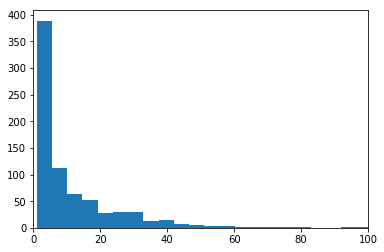

In [167]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(iy['day_diff'].value_counts(), bins=100)
plt.xlim(0, 100)
plt.show()

In [202]:
reinsp_index = iy.loc[iy['day_diff']<60].index

In [203]:
iy.shape

(11890, 27)

In [204]:
reinsp_index

Int64Index([    3,    13,    15,    17,    19,    23,    26,    28,    32,
               35,
            ...
            11852, 11853, 11859, 11862, 11865, 11868, 11877, 11882, 11883,
            11888],
           dtype='int64', length=3154)

In [221]:
iy_ready = iy.loc[~iy.index.isin(reinsp_index)]
iy_ready.to_csv('../dataset/iy_ready.csv')

In [222]:
# Now it's ready to merge with text mining data

## 2.3 Add cuisine category information

In [9]:
iy = pd.read_csv('../dataset/iy_ready.csv')

In [10]:
del iy['Unnamed: 0']

In [66]:
iy.head(3)

,Encounter,ID,Facility Name,Bus St Date,Description,NUM,Street,City,ZIP,Inspect Dt,...,categories,city,name,neighborhood,postal_code,review_count,stars,state,day_diff,price
0,201201030015,44322,Michael's Pizza Bar Restaurant,1989-01-31,Restaurant with Liquor,2612,Sarah St,Pittsburgh,15203,2012-01-03,...,"['Pizza', 'Restaurants']",Pittsburgh,Michael's Pizza Bar & Restaurant,South Side,15203,68,4.0,PA,NaN,1
1,201301280030,44322,Michael's Pizza Bar Restaurant,1989-01-31,Restaurant with Liquor,2612,Sarah St,Pittsburgh,15203,2013-01-28,...,"['Pizza', 'Restaurants']",Pittsburgh,Michael's Pizza Bar & Restaurant,South Side,15203,68,4.0,PA,391.0,1
2,201401060017,44322,Michael's Pizza Bar Restaurant,1989-01-31,Restaurant with Liquor,2612,Sarah St,Pittsburgh,15203,2014-01-03,...,"['Pizza', 'Restaurants']",Pittsburgh,Michael's Pizza Bar & Restaurant,South Side,15203,68,4.0,PA,340.0,1


In [76]:
# Add price level
def get_prices(x):
    dic = ast.literal_eval(x)
    try:
        output = dic['RestaurantsPriceRange2']
    except:
        output = np.nan 
    return output
iy['price'] = iy['attributes'].apply(get_prices)

In [77]:
iy['price'].value_counts()

2.0    4451
1.0    3405
3.0     293
4.0      35
Name: price, dtype: int64

In [54]:
# Add cuisine type
li = set([''])
for i in iy.itertuples():    
    cat = ast.literal_eval(i[19])
    li = li.union(set(cat))

li = list(li)
indices = [8, 10, 14, 15, 27, 31, 33, 36, 40, 47, 53, 54, 63, 65, 66, 69, 70, 75, 78, 80, 86, 91, 104, 109, 111, 113, 115, 117, 118, 120, 126, 128, 133, 137, 142, 143, 146, 148, 149, 158, 160, 164, 172, 174, 184, 187, 189, 195, 201, 205, 207, 210, 213, 220, 223, 228, 234, 236, 246, 258]

cuis_cat = []
for i in indices:
    cuis_cat.append(li[i])

{'',
 'Active Life',
 'Adult Entertainment',
 'Advertising',
 'African',
 'American (New)',
 'American (Traditional)',
 'Amusement Parks',
 'Antiques',
 'Arabian',
 'Arcades',
 'Argentine',
 'Armenian',
 'Art Galleries',
 'Arts & Crafts',
 'Arts & Entertainment',
 'Asian Fusion',
 'Attraction Farms',
 'Automotive',
 'Bagels',
 'Bakeries',
 'Bangladeshi',
 'Barbeque',
 'Bars',
 'Bartenders',
 'Basque',
 'Beaches',
 'Beauty & Spas',
 'Bed & Breakfast',
 'Beer',
 'Beer Bar',
 'Beer Gardens',
 'Belgian',
 'Beverage Store',
 'Bistros',
 'Boat Dealers',
 'Bowling',
 'Brasseries',
 'Breakfast & Brunch',
 'Breweries',
 'British',
 'Bubble Tea',
 'Buffets',
 'Burgers',
 'Burmese',
 'Butcher',
 'CSA',
 'Cafes',
 'Cafeteria',
 'Cajun/Creole',
 'Cambodian',
 'Candy Stores',
 'Cantonese',
 'Car Dealers',
 'Car Wash',
 'Cards & Stationery',
 'Caribbean',
 'Casinos',
 'Caterers',
 'Champagne Bars',
 'Cheese Shops',
 'Cheesesteaks',
 'Chicken Shop',
 'Chicken Wings',
 'Chinese',
 'Chocolatiers & Shops

In [71]:
for i in iy.itertuples():
    cat = ast.literal_eval(i[19])
    
    for cuis in cuis_cat:
        if np.isin(cat, cuis).any():
            iy.loc[i[0], "cuisine_"+cuis] = 1

In [88]:
iy.iloc[:,28:] = iy.iloc[:,28:].fillna(0)
iy.iloc[:,28:] = iy.iloc[:,28:].astype(np.int8)

In [99]:
# Remove low frequency labels to reduce the dimension in the dataset
others = iy.iloc[:,28:].sum()[iy.iloc[:,28:].sum()<100].keys()
others = pd.Series(others).str.split('_').str[1]

In [107]:
cuis_cat = list(set(cuis_cat) - set(others))

In [110]:
iy = iy.iloc[:,:28]

In [113]:
for i in iy.itertuples():
    cat = ast.literal_eval(i[19])
    
    for cuis in cuis_cat:
        if np.isin(cat, cuis).any():
            iy.loc[i[0], "cuisine_"+cuis] = 1
    for cuis in list(others): # handle minor cuisines
        if np.isin(cat, cuis).any():
            iy.loc[i[0], "cuisine_others"] = 1

In [115]:
iy.iloc[:,28:] = iy.iloc[:,28:].fillna(0)
iy.iloc[:,28:] = iy.iloc[:,28:].astype(np.int8)

In [118]:
iy.to_csv('../dataset/iy_ready2.csv')